# Bayesian Analysis of Racial Composition Percentages, Compactness Metrics, and Partisan Outcomes in Texas Congressional Districts

## Import Needed Libraries and Filepaths

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import invgamma, multivariate_normal, norm
import matplotlib.pyplot as plt
from texas_gerrymandering_hb4.config import FINAL_CSV

In [3]:
plt.rcParams["figure.figsize"] = (7, 5)

# Load dataset
df = pd.read_csv(FINAL_CSV)

# Keep only the columns we need
cols = [
    "district_id",
    "polsby_popper",
    "schwartzberg",
    "convex_hull_ratio",
    "reock",
    "pct_white",
    "pct_black",
    "pct_asian",
    "pct_hispanic",
    "dem_share",
    "rep_share",
]
df = df[cols].copy()

df.head()


2025-12-01 15:40:49.772 | INFO     | texas_gerrymandering_hb4.config:<module>:11 - PROJ_ROOT path is: /home/algorithmicprogrammer/Documents/texas-gerrymandering-hb4


,district_id,polsby_popper,schwartzberg,convex_hull_ratio,reock,pct_white,pct_black,pct_asian,pct_hispanic,dem_share,rep_share
0,1,0.193575,0.439971,0.722970,0.407570,0.632532,0.184984,0.014875,0.142830,0.252671,0.728964
1,2,0.165232,0.406487,0.625270,0.417351,0.526751,0.125050,0.072934,0.255189,0.399379,0.577517
2,3,0.216761,0.465576,0.805445,0.273916,0.577914,0.112669,0.111327,0.172895,0.403698,0.573637
3,4,0.103462,0.321654,0.574190,0.222752,0.605524,0.099241,0.157600,0.108877,0.405732,0.575123
4,5,0.184465,0.429494,0.823171,0.310183,0.522819,0.159980,0.034848,0.261670,0.481179,0.498040


In [4]:
# CELL 1 — Basic exploration

df.describe()


,district_id,polsby_popper,schwartzberg,convex_hull_ratio,reock,pct_white,pct_black,pct_asian,pct_hispanic,dem_share,rep_share
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,19.500000,0.221837,0.462684,0.686965,0.344703,0.432275,0.127905,0.061597,0.363117,0.463681,0.512114
std,11.113055,0.087745,0.089275,0.108347,0.103902,0.172452,0.095396,0.043399,0.203711,0.136927,0.138389
min,1.000000,0.103462,0.321654,0.454287,0.165108,0.087889,0.007249,0.008299,0.108877,0.246983,0.182716
25%,10.250000,0.148064,0.384748,0.612695,0.268179,0.299146,0.075779,0.031831,0.221054,0.396256,0.498070
50%,19.500000,0.207411,0.455389,0.713085,0.330677,0.511973,0.105150,0.049908,0.300803,0.407771,0.567241
75%,28.750000,0.286335,0.535102,0.762911,0.443395,0.564467,0.153358,0.077613,0.478241,0.480319,0.581235
max,38.000000,0.532031,0.729405,0.839023,0.506242,0.636540,0.467171,0.204011,0.892687,0.793258,0.729189


## Visualization of Distributions

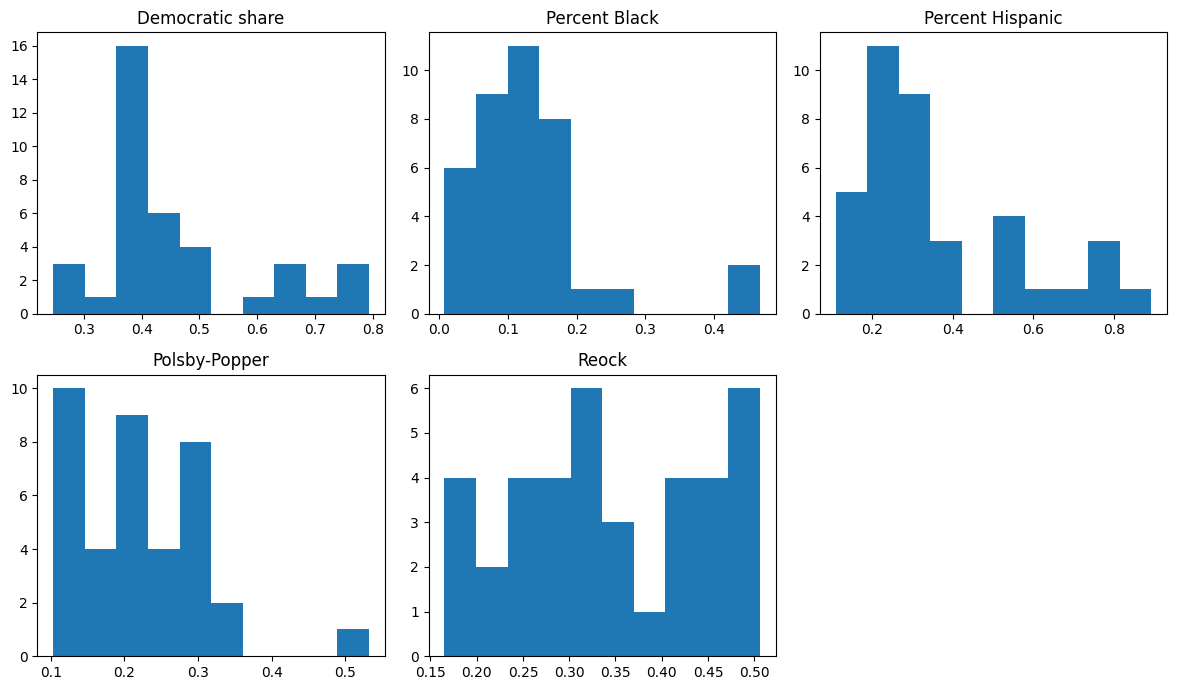

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(12, 7))

axes = axes.ravel()

axes[0].hist(df["dem_share"], bins=10)
axes[0].set_title("Democratic share")

axes[1].hist(df["pct_black"], bins=10)
axes[1].set_title("Percent Black")

axes[2].hist(df["pct_hispanic"], bins=10)
axes[2].set_title("Percent Hispanic")

axes[3].hist(df["polsby_popper"], bins=10)
axes[3].set_title("Polsby-Popper")

axes[4].hist(df["reock"], bins=10)
axes[4].set_title("Reock")

axes[5].axis("off")

plt.tight_layout()
plt.show()


In [6]:
# CELL 3 — Construct design matrix and standardize predictors

# Outcome as proportion (ensure it's in [0,1])
y = df["dem_share"].values
n = len(y)

# Choose predictors
predictors = [
    "pct_black",
    "pct_hispanic",
    "pct_asian",
    # leave out pct_white to avoid collinearity
    "polsby_popper",
    "reock",
    "schwartzberg",
]

X_raw = df[predictors].values

# Standardize predictors
X_mean = X_raw.mean(axis=0)
X_std = X_raw.std(axis=0, ddof=1)
X_std[X_std == 0] = 1.0  # avoid divide-by-zero

X = (X_raw - X_mean) / X_std

# Add intercept column
X = np.column_stack([np.ones(n), X])
p = X.shape[1]

predictors_with_intercept = ["intercept"] + predictors
predictors_with_intercept


['intercept',
 'pct_black',
 'pct_hispanic',
 'pct_asian',
 'polsby_popper',
 'reock',
 'schwartzberg']

## Gibbs Sampler Implementation for Bayesian Linear Regression

### Set Up Reproducible Random Number Generator

In [ ]:
np.random.seed(123)

In [7]:
# Prior hyperparameters
beta0 = np.zeros(p)
tau2 = 10.0**2
V0 = tau2 * np.eye(p)

alpha0 = 2.0
beta0_sigma = 1.0

# Initialize
beta_curr = np.zeros(p)
sigma2_curr = 1.0

n_iter = 20000
burn_in = 5000

beta_samples = np.zeros((n_iter, p))
sigma2_samples = np.zeros(n_iter)

XtX = X.T @ X
Xty = X.T @ y
V0_inv = np.linalg.inv(V0)

for it in range(n_iter):
    # --- Sample beta | sigma2, y ---
    Vn_inv = XtX / sigma2_curr + V0_inv
    Vn = np.linalg.inv(Vn_inv)
    mn = Vn @ (Xty / sigma2_curr + V0_inv @ beta0)
    beta_curr = multivariate_normal.rvs(mean=mn, cov=Vn)

    # --- Sample sigma2 | beta, y ---
    residual = y - X @ beta_curr
    alpha_n = alpha0 + n / 2.0
    beta_n = beta0_sigma + 0.5 * (residual @ residual)
    sigma2_curr = invgamma.rvs(a=alpha_n, scale=beta_n)

    beta_samples[it, :] = beta_curr
    sigma2_samples[it] = sigma2_curr

# Discard burn-in
beta_post = beta_samples[burn_in:, :]
sigma2_post = sigma2_samples[burn_in:]
beta_post.shape, sigma2_post.shape


((15000, 7), (15000,))

In [8]:
# CELL 5 — Posterior summaries for beta

def quantile_summary(samples, probs=(0.025, 0.25, 0.5, 0.75, 0.975)):
    return np.quantile(samples, probs, axis=0)

probs = (0.025, 0.25, 0.5, 0.75, 0.975)
beta_q = quantile_summary(beta_post, probs=probs)

summary_rows = []
for j, name in enumerate(predictors_with_intercept):
    row = {
        "parameter": name,
        "mean": beta_post[:, j].mean(),
    }
    for p_, qv in zip(probs, beta_q[:, j]):
        row[f"{int(p_ * 100)}%"] = qv
    summary_rows.append(row)

beta_summary = pd.DataFrame(summary_rows)
beta_summary


,parameter,mean,2%,25%,50%,75%,97%
0,intercept,0.464108,0.380585,0.436283,0.464466,0.492186,0.546279
1,pct_black,0.091549,0.004138,0.061643,0.091545,0.121346,0.180291
2,pct_hispanic,0.112556,0.008516,0.077519,0.112821,0.147135,0.218123
3,pct_asian,0.062041,-0.051676,0.023461,0.061903,0.100283,0.176881
4,polsby_popper,-0.106437,-0.781988,-0.335908,-0.103546,0.122527,0.570808
5,reock,0.022639,-0.089780,-0.014800,0.023315,0.061031,0.132766
6,schwartzberg,0.081097,-0.622901,-0.155858,0.076922,0.318070,0.790807


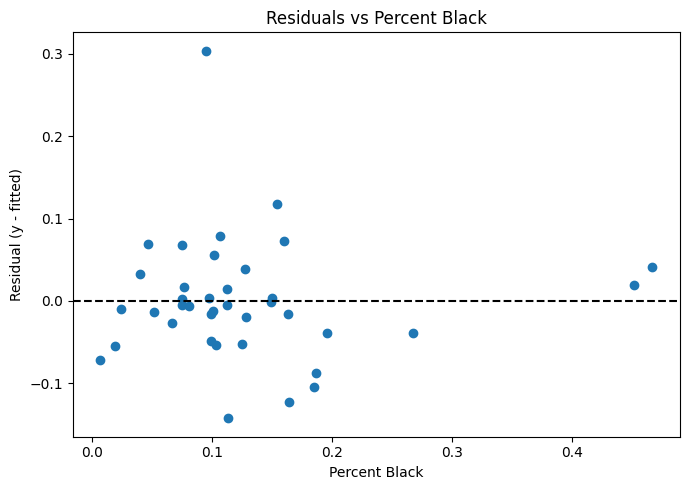

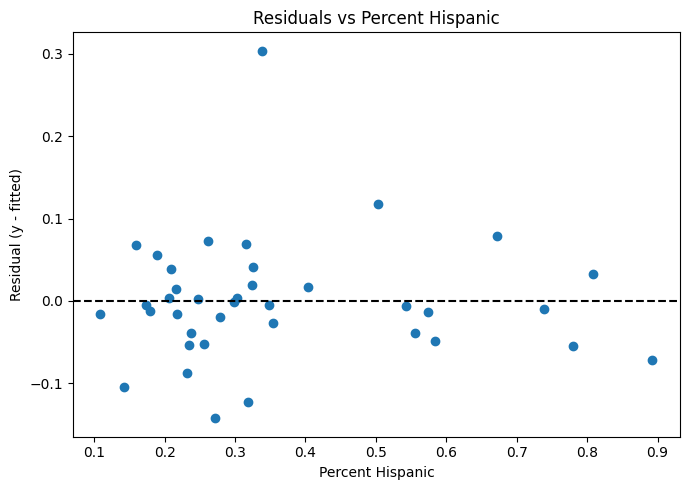

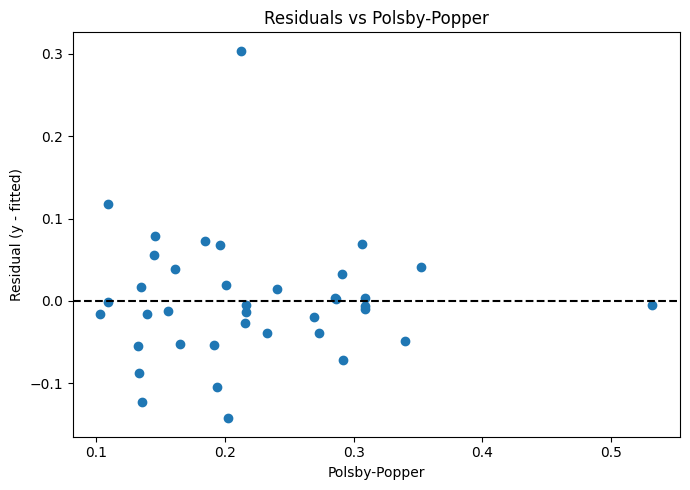

In [9]:
# CELL 6 — Posterior predictive distribution and residuals

# Use posterior draws to compute fitted values and residuals
# We'll use the posterior mean of beta for a simple fitted line,
# and then do full posterior predictive checks below.

beta_hat = beta_post.mean(axis=0)
y_hat = X @ beta_hat
residuals = y - y_hat

plt.scatter(df["pct_black"], residuals)
plt.axhline(0.0, color="k", linestyle="--")
plt.xlabel("Percent Black")
plt.ylabel("Residual (y - fitted)")
plt.title("Residuals vs Percent Black")
plt.tight_layout()
plt.show()

plt.scatter(df["pct_hispanic"], residuals)
plt.axhline(0.0, color="k", linestyle="--")
plt.xlabel("Percent Hispanic")
plt.ylabel("Residual (y - fitted)")
plt.title("Residuals vs Percent Hispanic")
plt.tight_layout()
plt.show()

plt.scatter(df["polsby_popper"], residuals)
plt.axhline(0.0, color="k", linestyle="--")
plt.xlabel("Polsby-Popper")
plt.ylabel("Residual (y - fitted)")
plt.title("Residuals vs Polsby-Popper")
plt.tight_layout()
plt.show()


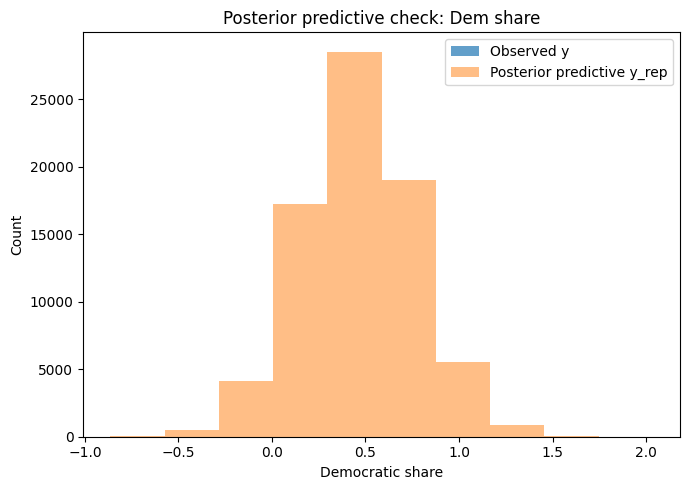

In [10]:
# CELL 7 — Posterior predictive samples

n_post = beta_post.shape[0]
n_rep = 2000  # number of posterior samples to use for predictive checks
idx = np.random.choice(n_post, size=n_rep, replace=False)

y_rep = np.zeros((n_rep, n))

for s, k in enumerate(idx):
    beta_s = beta_post[k, :]
    sigma_s = np.sqrt(sigma2_post[k])
    mu_s = X @ beta_s
    y_rep[s, :] = np.random.normal(loc=mu_s, scale=sigma_s)

# Compare distributions of observed y and replicated y
plt.hist(y, bins=10, alpha=0.7, label="Observed y")
plt.hist(y_rep.ravel(), bins=10, alpha=0.5, label="Posterior predictive y_rep")
plt.xlabel("Democratic share")
plt.ylabel("Count")
plt.title("Posterior predictive check: Dem share")
plt.legend()
plt.tight_layout()
plt.show()


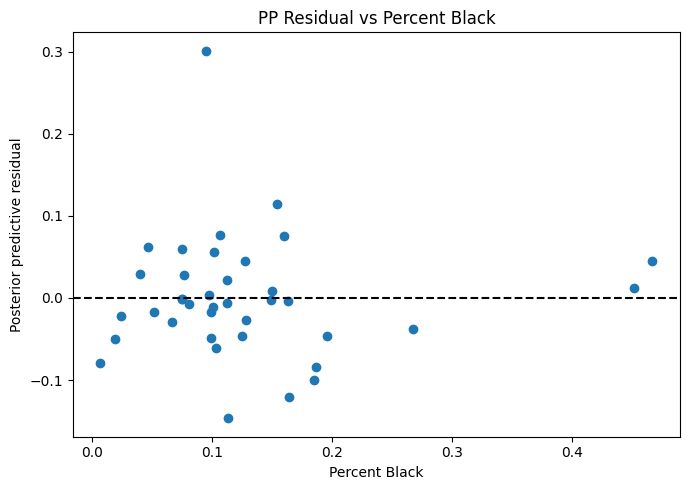

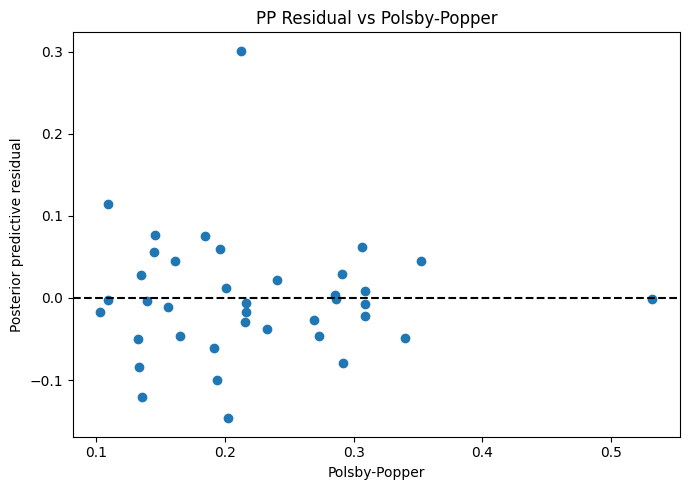

In [11]:
# CELL 8 — Residual-like quantity from posterior predictive

# Compute posterior predictive mean for each district
y_rep_mean = y_rep.mean(axis=0)
pp_resid = y - y_rep_mean

plt.scatter(df["pct_black"], pp_resid)
plt.axhline(0.0, color="k", linestyle="--")
plt.xlabel("Percent Black")
plt.ylabel("Posterior predictive residual")
plt.title("PP Residual vs Percent Black")
plt.tight_layout()
plt.show()

plt.scatter(df["polsby_popper"], pp_resid)
plt.axhline(0.0, color="k", linestyle="--")
plt.xlabel("Polsby-Popper")
plt.ylabel("Posterior predictive residual")
plt.title("PP Residual vs Polsby-Popper")
plt.tight_layout()
plt.show()


In [12]:
# CELL 9 — Second-stage regression: residuals ~ compactness

r = pp_resid
Z_raw = df[["polsby_popper", "reock", "schwartzberg"]].values
Z_mean = Z_raw.mean(axis=0)
Z_std = Z_raw.std(axis=0, ddof=1)
Z_std[Z_std == 0] = 1.0
Z = (Z_raw - Z_mean) / Z_std

Z = np.column_stack([np.ones(n), Z])
q = Z.shape[1]

# Prior hyperparameters for gamma, tau2
gamma0 = np.zeros(q)
tau2_gamma = 10.0**2
W0 = tau2_gamma * np.eye(q)

alpha0_r = 2.0
beta0_r = 1.0

gamma_curr = np.zeros(q)
tau2_curr = 1.0

n_iter_r = 15000
burn_in_r = 5000

gamma_samples = np.zeros((n_iter_r, q))
tau2_samples = np.zeros(n_iter_r)

ZtZ = Z.T @ Z
Ztr = Z.T @ r
W0_inv = np.linalg.inv(W0)

for it in range(n_iter_r):
    # gamma | tau2, r
    Wn_inv = ZtZ / tau2_curr + W0_inv
    Wn = np.linalg.inv(Wn_inv)
    gn = Wn @ (Ztr / tau2_curr + W0_inv @ gamma0)
    gamma_curr = multivariate_normal.rvs(mean=gn, cov=Wn)

    # tau2 | gamma, r
    res_r = r - Z @ gamma_curr
    alpha_n_r = alpha0_r + n / 2.0
    beta_n_r = beta0_r + 0.5 * (res_r @ res_r)
    tau2_curr = invgamma.rvs(a=alpha_n_r, scale=beta_n_r)

    gamma_samples[it, :] = gamma_curr
    tau2_samples[it] = tau2_curr

gamma_post = gamma_samples[burn_in_r:, :]
tau2_post = tau2_samples[burn_in_r:]

gamma_summary = []
for j, name in enumerate(["intercept", "polsby_popper", "reock", "schwartzberg"]):
    row = {
        "parameter": name,
        "mean": gamma_post[:, j].mean(),
        "2.5%": np.quantile(gamma_post[:, j], 0.025),
        "50%": np.quantile(gamma_post[:, j], 0.5),
        "97.5%": np.quantile(gamma_post[:, j], 0.975),
    }
    gamma_summary.append(row)

pd.DataFrame(gamma_summary)


,parameter,mean,2.5%,50%,97.5%
0,intercept,-0.001042,-0.077648,-0.000943,0.077333
1,polsby_popper,0.014134,-0.632373,0.014196,0.672224
2,reock,0.000787,-0.107438,0.000644,0.108534
3,schwartzberg,-0.015208,-0.686822,-0.013880,0.646193


In [13]:
# CELL 10 — Mixture-of-normals on dem_share

np.random.seed(456)

y = df["dem_share"].values
n = len(y)

# Hyperparameters
alpha1 = 2.0
alpha2 = 2.0

m0 = y.mean()
s0_sq = (y.std(ddof=1) ** 2) * 4  # fairly wide prior

a0 = 2.0
b0 = 1.0

# Initialize
z = np.random.randint(0, 2, size=n)  # 0 or 1 for two components
lambda_curr = 0.5
mu_curr = np.array([y.mean() - 0.05, y.mean() + 0.05])
sigma2_curr = np.array([y.var(), y.var()])

n_iter_mix = 20000
burn_in_mix = 5000

lambda_samples = np.zeros(n_iter_mix)
mu_samples = np.zeros((n_iter_mix, 2))
sigma2_samples_mix = np.zeros((n_iter_mix, 2))
z_samples = np.zeros((n_iter_mix, n), dtype=int)

for it in range(n_iter_mix):
    # --- Sample z_i ---
    for i in range(n):
        # likelihood for each component
        ll0 = norm.pdf(y[i], loc=mu_curr[0], scale=np.sqrt(sigma2_curr[0]))
        ll1 = norm.pdf(y[i], loc=mu_curr[1], scale=np.sqrt(sigma2_curr[1]))
        p0 = lambda_curr * ll0
        p1 = (1 - lambda_curr) * ll1
        denom = p0 + p1
        if denom == 0:
            p0 = p1 = 0.5
        else:
            p0 /= denom
            p1 /= denom
        z[i] = np.random.choice([0, 1], p=[p0, p1])

    # --- Sample lambda ---
    n0 = np.sum(z == 0)
    n1 = n - n0
    lambda_curr = np.random.beta(alpha1 + n0, alpha2 + n1)

    # --- Sample (mu_k, sigma2_k) for each component ---
    for k in [0, 1]:
        yk = y[z == k]
        nk = len(yk)
        if nk > 0:
            yk_mean = yk.mean()
            # Posterior for sigma2_k
            ak = a0 + nk / 2.0
            # Use Normal-Inverse-Gamma updating
            # Prior on mu_k: Normal(m0, s0_sq)
            # Equivalent combined for sigma2:
            # Sum of squared devs plus prior contribution
            ssq = np.sum((yk - yk_mean) ** 2)
            # For Normal-Inverse-Gamma, we can do:
            # b_k = b0 + 0.5 * [ssq + (nk * s0_sq * (yk_mean - m0)^2) / (nk * s0_sq + s0_sq)]
            # To keep it simple, treat sigma2 and mu as if independent w.r.t. the prior and use:
            bk = b0 + 0.5 * ssq
            sigma2_curr[k] = invgamma.rvs(a=ak, scale=bk)

            # Posterior for mu_k given sigma2_k:
            s2_post = 1 / (nk / sigma2_curr[k] + 1 / s0_sq)
            m_post = s2_post * (nk * yk_mean / sigma2_curr[k] + m0 / s0_sq)
            mu_curr[k] = np.random.normal(loc=m_post, scale=np.sqrt(s2_post))
        else:
            # if no data in component, just draw from prior
            sigma2_curr[k] = invgamma.rvs(a=a0, scale=b0)
            mu_curr[k] = np.random.normal(loc=m0, scale=np.sqrt(s0_sq))

    lambda_samples[it] = lambda_curr
    mu_samples[it, :] = mu_curr
    sigma2_samples_mix[it, :] = sigma2_curr
    z_samples[it, :] = z

# Discard burn-in
lambda_post = lambda_samples[burn_in_mix:]
mu_post = mu_samples[burn_in_mix:, :]
sigma2_post_mix = sigma2_samples_mix[burn_in_mix:, :]
z_post = z_samples[burn_in_mix:, :]

lambda_post.mean(), mu_post.mean(axis=0)


(np.float64(0.39144345998584396), array([0.4678701 , 0.46401695]))

In [14]:
# CELL 11 — Summaries and posterior mixture classification

lambda_mean = lambda_post.mean()
mu_mean = mu_post.mean(axis=0)
sigma_mean = np.sqrt(sigma2_post_mix.mean(axis=0))

print("Posterior mean lambda:", lambda_mean)
print("Posterior mean mu0, mu1:", mu_mean)
print("Posterior mean sigma0, sigma1:", sigma_mean)

# Compute posterior probability for each district of being in component 1
p_comp1 = (z_post == 1).mean(axis=0)  # shape: (n,)

# Label each district by MAP component
map_comp = (p_comp1 > 0.5).astype(int)

df["mix_comp"] = map_comp
df["p_comp1"] = p_comp1

df[["district_id", "dem_share", "mix_comp", "p_comp1"]].head()


Posterior mean lambda: 0.39144345998584396
Posterior mean mu0, mu1: [0.4678701  0.46401695]
Posterior mean sigma0, sigma1: [0.66964944 0.53065295]


,district_id,dem_share,mix_comp,p_comp1
0,1,0.252671,1,0.616267
1,2,0.399379,1,0.622200
2,3,0.403698,1,0.621600
3,4,0.405732,1,0.618533
4,5,0.481179,1,0.619133


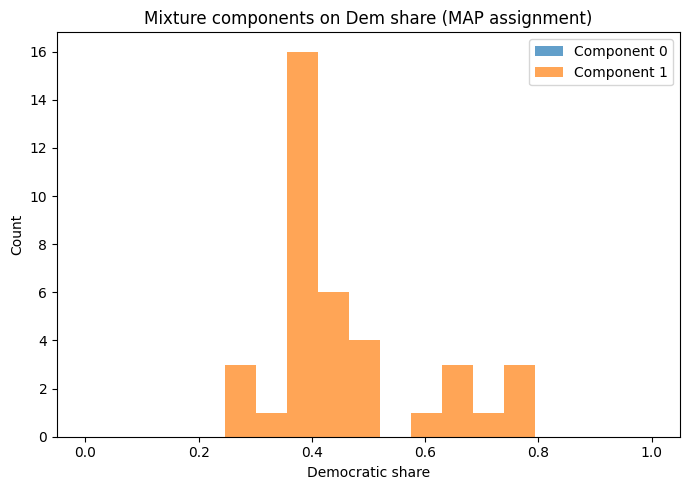

In [15]:
# CELL 12 — Visual comparison of components

plt.hist(y[map_comp == 0], bins=10, alpha=0.7, label="Component 0")
plt.hist(y[map_comp == 1], bins=10, alpha=0.7, label="Component 1")
plt.xlabel("Democratic share")
plt.ylabel("Count")
plt.title("Mixture components on Dem share (MAP assignment)")
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
# CELL 13 — Regression: posterior component prob ~ race + compactness

p_resp = p_comp1  # use posterior prob of being in component 1

# Design matrix for this regression
W_raw = df[["pct_black", "pct_hispanic", "pct_asian", "polsby_popper", "reock", "schwartzberg"]].values
W_mean = W_raw.mean(axis=0)
W_std = W_raw.std(axis=0, ddof=1)
W_std[W_std == 0] = 1.0
W_stdzd = (W_raw - W_mean) / W_std

W = np.column_stack([np.ones(n), W_stdzd])
r_dim = W.shape[1]

delta0 = np.zeros(r_dim)
tau2_delta = 10.0**2
R0 = tau2_delta * np.eye(r_dim)

alpha0_p = 2.0
beta0_p = 1.0

delta_curr = np.zeros(r_dim)
omega2_curr = 0.1

n_iter_p = 15000
burn_in_p = 5000

delta_samples = np.zeros((n_iter_p, r_dim))
omega2_samples = np.zeros(n_iter_p)

WtW = W.T @ W
Wtp = W.T @ p_resp
R0_inv = np.linalg.inv(R0)

for it in range(n_iter_p):
    # delta | omega2, p
    Rn_inv = WtW / omega2_curr + R0_inv
    Rn = np.linalg.inv(Rn_inv)
    dn = Rn @ (Wtp / omega2_curr + R0_inv @ delta0)
    delta_curr = multivariate_normal.rvs(mean=dn, cov=Rn)

    # omega2 | delta, p
    res_p = p_resp - W @ delta_curr
    alpha_n_p = alpha0_p + n / 2.0
    beta_n_p = beta0_p + 0.5 * (res_p @ res_p)
    omega2_curr = invgamma.rvs(a=alpha_n_p, scale=beta_n_p)

    delta_samples[it, :] = delta_curr
    omega2_samples[it] = omega2_curr

delta_post = delta_samples[burn_in_p:, :]
omega2_post = omega2_samples[burn_in_p:]

delta_summary = []
for j, name in enumerate(["intercept"] + ["pct_black", "pct_hispanic", "pct_asian", "polsby_popper", "reock", "schwartzberg"]):
    row = {
        "parameter": name,
        "mean": delta_post[:, j].mean(),
        "2.5%": np.quantile(delta_post[:, j], 0.025),
        "50%": np.quantile(delta_post[:, j], 0.5),
        "97.5%": np.quantile(delta_post[:, j], 0.975),
    }
    delta_summary.append(row)

pd.DataFrame(delta_summary)


,parameter,mean,2.5%,50%,97.5%
0,intercept,0.620520,0.542926,0.620323,0.699631
1,pct_black,-0.002066,-0.088154,-0.002057,0.081231
2,pct_hispanic,0.000170,-0.097386,-0.000003,0.098511
3,pct_asian,-0.000225,-0.104605,-0.000736,0.106484
4,polsby_popper,-0.001089,-0.655224,-0.000395,0.653601
5,reock,0.000129,-0.105124,0.000629,0.105144
6,schwartzberg,0.001140,-0.677230,0.002214,0.672103
